In [8]:
import sys
sys.path.append("..")
import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import nidaqmx
import numpy as np
from LowLevelModules.NIdaq import *
from LowLevelModules.NIdaqAPD import *
from LowLevelModules.GeneralFunctions import *
import time
#from collections import deque

class FSM:
    def __init__(self, x0=0, y0=0):
        self.position = {'x': x0, 'y': y0}    # this line will run setter function of position property
        curr_x, curr_y = self.read_position()
        self.position = {'x': curr_x, 'y': curr_y}    # this line will run setter function of position property
#         self.conversion = {'x': 13.90, 'y': 9.69}     # um/volt for 50x Olympus obj
        self.conversion = {'x': 6.22, 'y': 8.58} # um/volt for 100x Olympus obj
#     @property
#     def position(self, unit='volts'):
#         return self._position
        
#     @position.setter
#     def position(self, new_pos=(0,0)):
#         # set the new current position
#         self._position = new_pos
    
    def micron_to_volts(self, pos_in_micron, axis):
        return pos_in_micron / self.conversion[axis]

    def volts_to_micron(self, pos_in_volts, axis):
        return pos_in_volts * self.conversion[axis]

    def read_position(self, unit='volts'):
        """ Voltage reading of the 2 AI from the DAQ
            Returns in Volts unless asked otherwise """
        with nidaqmx.Task() as fsm_task:
            fsm_task.ai_channels.add_ai_voltage_chan('/Dev1/ai1', 'FSM x axis')
            fsm_task.ai_channels.add_ai_voltage_chan('/Dev1/ai0', 'FSM y axis')
            curr_x, curr_y = fsm_task.read()
        self.position['x'], self.position['y'] = curr_x, curr_y
        if unit != 'volts':
            curr_x = self.volts_to_micron(curr_x, 'x')
            curr_y = self.volts_to_micron(curr_y, 'y')
        return curr_x, curr_y

    def calc_trajectory_in_V(self, final_pos, n_pts, axis):
        """  Returns an array in volts of a sine-like profile 
             for sweeping the values from one position to the next """
        init_pos_V = self.position[axis]
        final_pos_V = self.micron_to_volts(final_pos, axis)
        delta_pos = final_pos_V - init_pos_V
        x_sine = np.linspace(-np.pi/2, np.pi/2, n_pts)
        sweep_array = (np.sin(x_sine) + 1)/2*(final_pos_V-init_pos_V) + init_pos_V
        return sweep_array

    def go_to_position(self, x, y):
        """ Smooth sinusoidal move from current position to (x,y) in um """
        #curr_x, curr_y = read_position('microns')
        curr_x = self.volts_to_micron(self.position['x'], 'x')
        curr_y = self.volts_to_micron(self.position['y'], 'y')
        nx = int(np.ceil((abs(x-curr_x)*500+10)/2))
        ny = int(np.ceil((abs(y-curr_y)*500+10)/2))    
        n_max = max(nx,ny)

        # 2 arrays need to have the same size
        xVsweep_array = self.calc_trajectory_in_V(x, n_max, 'x')
        yVsweep_array = self.calc_trajectory_in_V(y, n_max, 'y')

        with nidaqmx.Task() as task:
            task.ao_channels.add_ao_voltage_chan( '/Dev1/ao0', 'FSM y axis', min_val=-9, max_val=9)
            task.ao_channels.add_ao_voltage_chan('/Dev1/ao1', 'FSM x axis', min_val=-9, max_val=9)
            task.timing.cfg_samp_clk_timing(rate= 50000, 
                                            active_edge=nidaqmx.constants.Edge.RISING ,
                                            sample_mode= nidaqmx.constants.AcquisitionType.FINITE, 
                                            samps_per_chan=len(xVsweep_array))
            task.write(np.array([yVsweep_array, xVsweep_array]), auto_start=True, timeout=5)
            task.wait_until_done(timeout=5)

        # set the new current position
        curr_x, curr_y = self.read_position()
        self.position = {'x': curr_x, 'y': curr_y} 

    def scan_1D(self, x1, xf, mesh_pts=20, scan_rate=100, counter_terminal= "/Dev1/PFI5"):
        
        counterPort = "/Dev1/ctr1"
        mult_fac = 5

        ao_scan_rate = scan_rate*mult_fac
        ao_pts = mesh_pts*mult_fac

        # x trajectory 
        axis_scan = np.linspace(x1, xf, mesh_pts)

        # voltage scan is denser than the mesh
        v_ao_scan = self.micron_to_volts(np.linspace(x1, xf, ao_pts), 'x')

        # clock source
        counter_term_clk = '/Dev1/ctr0'
        trig_src =  '/Dev1/PFI12'       

        # setup counter
        countAPD = CI(counter_terminal, counterPort)
        countAPD.config_read_samples(trig_src, mesh_pts + 1, scan_rate)        

        # set up FSM AO AI
        FSMXtask = AO('/Dev1/ao1')
        FSMXtask.config_write(v_ao_scan, ao_scan_rate, trig_src)

        FSMreadXtask = AI('/Dev1/ai1')
        FSMreadXtask.config_read(ao_pts, ao_scan_rate, trig_src)

        # PFI12 start
        # CREATE EXT CLOCK TO GATE THE READING OF PULSES COMING FROM THE APD
        ext_clock_task = CO(counter_term_clk, scan_rate)

        # wait until done and read data
        FSMXtask.wait_until_done()
        FSMXtask.close()

        aiV = FSMreadXtask.read(number_of_samples_per_channel=ao_pts)
        thisX = self.volts_to_micron(np.asarray(aiV), 'x')
        downSampleX = thisX[::mult_fac]
        FSMreadXtask.close()

        rawAPD=countAPD.read(number_of_samples_per_channel=mesh_pts+1)
        correctAPD = np.diff(rawAPD)*scan_rate/1000 # kHz

        countAPD.close()
        ext_clock_task.close()
        
        # edit (Harry) - update current position after 1D scan
        curr_x, curr_y = self.read_position()
        self.position = {'x': curr_x, 'y': curr_y} 
        return downSampleX, correctAPD     


In [9]:
class LivePlotFSM:
    def __init__(self, dims, x_data, y_data, z_data, xlabel='x', ylabel='y', zlabel='Cts'):
        self.fig, (self.ax1, self.ax2) = plt.subplots(2, 1, 
                                                      #sharex=True, 
                                                      figsize=dims, 
                                                      gridspec_kw={'height_ratios': [1, 2]})
        #current X scan in 1D
        self.ax1.plot(x_data, z_data[0,:])
        self.ax1.set_xlabel('', labelpad=10, fontsize=18)
        self.ax1.set_ylabel(zlabel, labelpad=10, fontsize=18)
        self.ax1.tick_params(axis='both', labelsize=16)
     
        #2D sub plot
        extent_x = (np.max(x_data) - np.min(x_data)) / 2
        extent_y = (np.max(y_data) - np.min(y_data)) / 2
        self.extent = [-extent_x, extent_x, -extent_y, extent_y]
        aspect_ratio = abs((x_data[-1] - x_data[0]) / (y_data[-1] - y_data[0]))
        self.cp2 = self.ax2.imshow(z_data, cmap='terrain', origin='center', extent=self.extent,
                                 interpolation='nearest', aspect=aspect_ratio)

        self.cb2 = self.fig.colorbar(self.cp2, fraction=0.046, pad=0.04)
        self.ax2.set_xlabel(xlabel, labelpad=10, fontsize=18)
        self.ax2.set_ylabel(ylabel, labelpad=10, fontsize=18)
        self.cb2.set_label(zlabel, labelpad=20, fontsize=18)
        self.cb2.ax.set_yticklabels(self.cb2.ax.get_yticklabels(), fontsize=16)
        self.ax2.tick_params(axis='both', labelsize=16)

        self.fig.show()
        self.fig.canvas.draw()
        self.fig.subplots_adjust(hspace=.3, left=0.15, bottom=0.15, right = 0.8)
        #self.fig.tight_layout()

    def plot_live(self, x_data, y_data, z_data):
        self.ax1.lines[0].set_xdata(x_data)
        self.ax1.lines[0].set_ydata(y_data)
        self.ax1.relim()
        self.ax1.autoscale_view()
    
        self.cp2.set_data(z_data)
        self.cb2.set_clim(vmin=np.min(z_data),vmax=np.max(z_data))
        self.cb2.draw_all()
        self.fig.canvas.draw()
        #self.fig.tight_layout()
        plt.pause(1e-7)


In [10]:
# initialize the FSM object
FSM1 = FSM()
curr_x, curr_y = FSM1.read_position()

In [33]:
FSM1.go_to_position(4.13,-0.66)

In [32]:
FSM1.read_position('microns')

(3.571850846367262, -0.31909081157431557)

<IPython.core.display.Javascript object>


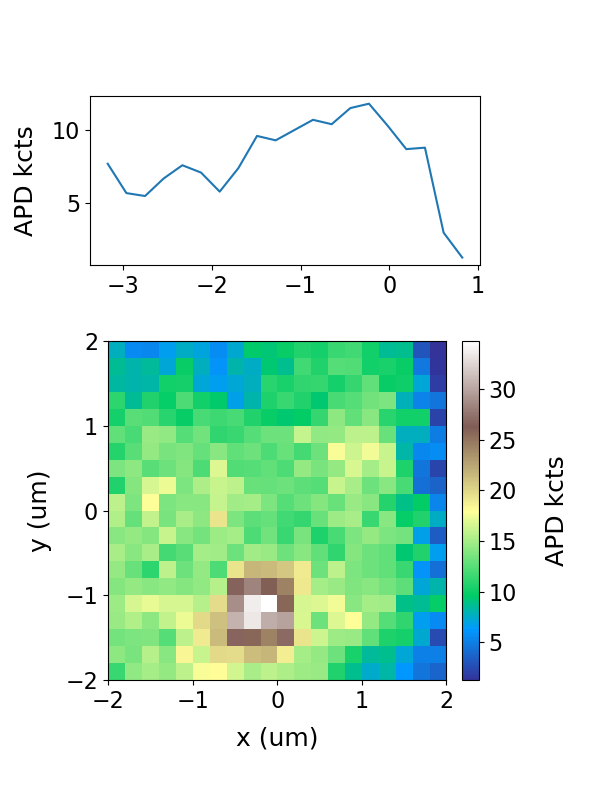

<IPython.core.display.Javascript object>


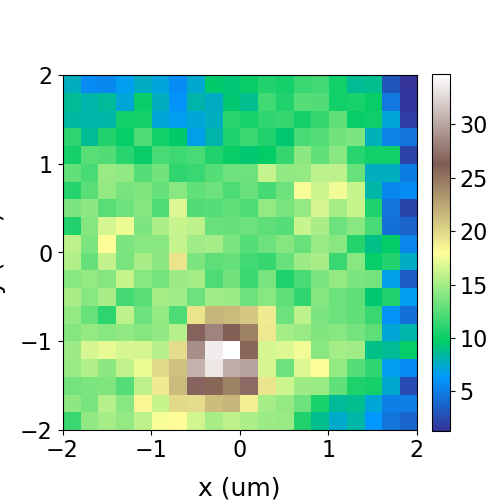

C:\data\191016\FSM-2D\FSM-2D_160433 Z.txt


In [8]:
#####################   USER INPUT   #####################
scan_size = 4    #um
mesh_size = 20    #um
scan_rate = 100   #Hz
save_data = True
##########################################################

curr_x, curr_y = FSM1.read_position('microns')
start_x = curr_x - scan_size/2
end_x = curr_x + scan_size/2

start_y = curr_y + scan_size/2
end_y = curr_y - scan_size/2

x_scan = np.linspace(start_x, end_x, mesh_size)
y_scan = np.linspace(start_y, end_y, mesh_size)

FSM2D = np.zeros((mesh_size, mesh_size))
lp = LivePlotFSM((6, 8), x_scan, y_scan, FSM2D, 'x (um)', 'y (um)', 'APD kcts')

for i, y0 in enumerate(y_scan):
    try:
        FSM1.go_to_position(start_x, y0)
        xx, cts = FSM1.scan_1D(start_x, end_x, mesh_size, scan_rate)
        FSM2D[i,:] = cts
        lp.plot_live(x_scan, cts, FSM2D)

    except KeyboardInterrupt:
        # press the stop button to trigger this
        FSMXtask.close()
        FSMreadXtask.close()
        countAPD.close()
        ext_clock_task.close()
        break

plt.close(lp.fig)
# back to initial location
FSM1.go_to_position(curr_x, curr_y)
if save_data:
    #replot figure
    fig1, ax1 = plt.subplots(1, 1, figsize=(5,5))
    #2D sub plot
    extent_x = (np.max(x_scan) - np.min(x_scan)) / 2
    extent_y = (np.max(y_scan) - np.min(y_scan)) / 2
    extent = [-extent_x, extent_x, -extent_y, extent_y]
    aspect_ratio = abs((x_scan[-1] - x_scan[0]) / (y_scan[-1] - y_scan[0]))
    cp1 = ax1.imshow(FSM2D, cmap='terrain', origin='center', extent=extent,
                     interpolation='nearest', aspect=aspect_ratio)
    cb1 = fig1.colorbar(cp1, fraction=0.046, pad=0.04)
    ax1.set_xlabel('x (um)', labelpad=10, fontsize=18)
    ax1.set_ylabel('y (um)', labelpad=10, fontsize=18)
    cb1.set_label('APD counts (kHz)', labelpad=20, fontsize=18)
    cb1.ax.set_yticklabels(cb1.ax.get_yticklabels(), fontsize=16)
    ax1.tick_params(axis='both', labelsize=16)

    # rest of the info
    data_type = 'FSM-2D'
    save_file_names = data_save_2D(x_scan, y_scan, FSM2D, fig1, data_type)